# 캐글 경진대회 베이스라인 모델

## 라이브러리 임포트

In [10259]:
# 필요한 모듈 임포트
import os
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from plt_rcs import *
import hds
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import rankdata

## 데이터셋 준비

In [10260]:
# 작업 경로 변경
os.chdir('../data')

In [10261]:
# 현재 작업 경로에 있는 폴더명과 파일명 목록 확인
sorted(os.listdir())

['balanced_model.csv',
 'c_0046_model.csv',
 'c_004_model.csv',
 'c_005_model.csv',
 'cluster_null_model.csv',
 'leakage_cluster_null_model.csv',
 'leakage_load_bin_model.csv',
 'm_pca1_model.csv',
 'rm_m_pca1_model.csv',
 'sample_submission.csv',
 'test.csv',
 'train.csv']

In [10262]:
# 데이터셋 불러오기
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [10263]:
# 데이터셋 행 개수와 열 개수 확인
print(train.shape)
print(test.shape)

(26570, 26)
(20775, 25)


In [10264]:
# 훈련셋 처음 5행 확인
train.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [10265]:
# 훈련셋 정보 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26570 entries, 0 to 26569
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              26570 non-null  int64  
 1   product_code    26570 non-null  object 
 2   loading         26320 non-null  float64
 3   attribute_0     26570 non-null  object 
 4   attribute_1     26570 non-null  object 
 5   attribute_2     26570 non-null  int64  
 6   attribute_3     26570 non-null  int64  
 7   measurement_0   26570 non-null  int64  
 8   measurement_1   26570 non-null  int64  
 9   measurement_2   26570 non-null  int64  
 10  measurement_3   26189 non-null  float64
 11  measurement_4   26032 non-null  float64
 12  measurement_5   25894 non-null  float64
 13  measurement_6   25774 non-null  float64
 14  measurement_7   25633 non-null  float64
 15  measurement_8   25522 non-null  float64
 16  measurement_9   25343 non-null  float64
 17  measurement_10  25270 non-null 

In [10266]:
train.describe().round(5)

,id,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
count,26570.00000,26320.00000,26570.00000,26570.00000,26570.00000,26570.00000,26570.00000,26189.00000,26032.00000,25894.00000,...,25343.00000,25270.00000,25102.00000,24969.00000,24796.00000,24696.00000,24561.00000,24460.00000,24286.00000,26570.00000
mean,13284.50000,127.82623,6.75405,7.24046,7.41588,8.23252,6.25657,17.79153,11.73199,17.12780,...,11.43072,16.11771,19.17209,11.70246,15.65290,16.04844,14.99555,16.46073,701.26906,0.21261
std,7670.24266,39.03002,1.47185,1.45649,4.11669,4.19940,3.30911,1.00120,0.99608,0.99641,...,0.99914,1.40598,1.52079,1.48884,1.15525,1.49192,1.54923,1.70894,123.30416,0.40916
min,0.00000,33.16000,5.00000,5.00000,0.00000,0.00000,0.00000,13.96800,8.00800,12.07300,...,7.53700,9.32300,12.46100,5.16700,10.89000,9.14000,9.10400,9.70100,196.78700,0.00000
25%,6642.25000,99.98750,6.00000,6.00000,4.00000,5.00000,4.00000,17.11700,11.05100,16.44300,...,10.75700,15.20900,18.17000,10.70300,14.89000,15.05700,13.95700,15.26800,618.96150,0.00000
50%,13284.50000,122.39000,6.00000,8.00000,7.00000,8.00000,6.00000,17.78700,11.73300,17.13200,...,11.43000,16.12700,19.21150,11.71700,15.62850,16.04000,14.96900,16.43600,701.02450,0.00000
75%,19926.75000,149.15250,8.00000,8.00000,10.00000,11.00000,8.00000,18.46900,12.41000,17.80500,...,12.10200,17.02500,20.20700,12.70900,16.37400,17.08200,16.01800,17.62800,784.09025,0.00000
max,26569.00000,385.86000,9.00000,9.00000,29.00000,29.00000,24.00000,21.49900,16.48400,21.42500,...,15.41200,22.47900,25.64000,17.66300,22.71300,22.30300,21.62600,24.09400,1312.79400,1.00000


In [10267]:
# 훈련셋 열별 결측값 개수 확인
train.isna().sum()

id                   0
product_code         0
loading            250
attribute_0          0
attribute_1          0
attribute_2          0
attribute_3          0
measurement_0        0
measurement_1        0
measurement_2        0
measurement_3      381
measurement_4      538
measurement_5      676
measurement_6      796
measurement_7      937
measurement_8     1048
measurement_9     1227
measurement_10    1300
measurement_11    1468
measurement_12    1601
measurement_13    1774
measurement_14    1874
measurement_15    2009
measurement_16    2110
measurement_17    2284
failure              0
dtype: int64

In [10268]:
# 시험셋 처음 5행 확인
test.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,26570,F,119.57,material_5,material_6,6,4,6,9,6,...,18.654,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612
1,26571,F,113.51,material_5,material_6,6,4,11,8,0,...,19.368,12.032,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037
2,26572,F,112.16,material_5,material_6,6,4,8,12,4,...,17.774,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995
3,26573,F,112.72,material_5,material_6,6,4,8,11,10,...,18.948,11.790,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301
4,26574,F,208.00,material_5,material_6,6,4,14,16,8,...,19.141,12.370,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044


In [10269]:
# 시험셋 정보 확인
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20775 entries, 0 to 20774
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20775 non-null  int64  
 1   product_code    20775 non-null  object 
 2   loading         20552 non-null  float64
 3   attribute_0     20775 non-null  object 
 4   attribute_1     20775 non-null  object 
 5   attribute_2     20775 non-null  int64  
 6   attribute_3     20775 non-null  int64  
 7   measurement_0   20775 non-null  int64  
 8   measurement_1   20775 non-null  int64  
 9   measurement_2   20775 non-null  int64  
 10  measurement_3   20446 non-null  float64
 11  measurement_4   20366 non-null  float64
 12  measurement_5   20267 non-null  float64
 13  measurement_6   20151 non-null  float64
 14  measurement_7   20055 non-null  float64
 15  measurement_8   19929 non-null  float64
 16  measurement_9   19871 non-null  float64
 17  measurement_10  19708 non-null 

In [10270]:
# 시험셋 열별 결측값 개수 확인
test.isna().sum()

id                   0
product_code         0
loading            223
attribute_0          0
attribute_1          0
attribute_2          0
attribute_3          0
measurement_0        0
measurement_1        0
measurement_2        0
measurement_3      329
measurement_4      409
measurement_5      508
measurement_6      624
measurement_7      720
measurement_8      846
measurement_9      904
measurement_10    1067
measurement_11    1136
measurement_12    1240
measurement_13    1303
measurement_14    1440
measurement_15    1542
measurement_16    1678
measurement_17    1740
dtype: int64

In [10271]:
train.columns

Index(['id', 'product_code', 'loading', 'attribute_0', 'attribute_1',
       'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1',
       'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5',
       'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9',
       'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13',
       'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17',
       'failure'],
      dtype='object')

## 특성 행렬과 타겟 벡터로 분리

In [10272]:
# 타겟 벡터명 설정
yvar = 'failure'

# 훈련셋 특성 행렬 생성
X = train.drop(columns = yvar)

# 훈련셋 타겟 벡터 생성
y = train[yvar].copy()

In [10273]:
# 시험셋 특성 행렬 생성
X_test = test.copy()

## 데이터 전처리

In [10274]:
# 단순 식별자인 'id' 제거
X = X.drop(columns = 'id')
X_test = X_test.drop(columns = 'id')

In [10275]:
# 결측치 개수 피처 생성
X['null_count'] = X.isnull().sum(axis=1)
X_test['null_count'] = X_test.isnull().sum(axis=1)

In [10276]:
X['m17_isna'] = X['measurement_17'].isna().astype(int)
X_test['m17_isna'] = X_test['measurement_17'].isna().astype(int)

In [10277]:
from sklearn.cluster import KMeans

m_cols = ['loading', 'measurement_17', 'measurement_5', 'measurement_2', 'measurement_1']

X_missing_matrix = X[m_cols].isna().astype(int)
X_test_missing_matrix = X_test[m_cols].isna().astype(int)

km = KMeans(n_clusters=3, random_state=42, n_init=10)

X['cluster_null'] = km.fit_predict(X_missing_matrix)
X_test['cluster_null'] = km.predict(X_test_missing_matrix)
X['cluster_null'] = X['cluster_null'].astype(object)
X_test['cluster_null'] = X_test['cluster_null'].astype(object)

In [10278]:
# 수치형 특성만 선택
numeric_features = X.select_dtypes(include = ['int64', 'float64']).columns.tolist()

# 수치형 특성 목록 확인
print(numeric_features)

['loading', 'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17', 'null_count', 'm17_isna']


In [10279]:
# 범주형 특성만 선택
categorical_features = X.select_dtypes(include = ['object']).columns.tolist()

# 범주형 특성 목록 확인
print(categorical_features)

['product_code', 'attribute_0', 'attribute_1', 'cluster_null']


## 결측값 전처리

In [10280]:
train.columns

Index(['id', 'product_code', 'loading', 'attribute_0', 'attribute_1',
       'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1',
       'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5',
       'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9',
       'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13',
       'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17',
       'failure'],
      dtype='object')

In [10281]:
from sklearn.linear_model import Ridge

meas_features_for_17 = ['loading', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8']

for col in meas_features_for_17:
    m_median = X[col].median()
    X[col] = X[col].fillna(m_median)
    X_test[col] = X_test[col].fillna(m_median)

train_mask = X['measurement_17'].notna()
reg = Ridge(alpha=0.1)
reg.fit(X.loc[train_mask, meas_features_for_17], X.loc[train_mask, 'measurement_17'])

null_mask = X['measurement_17'].isna()
X.loc[null_mask, 'measurement_17'] = reg.predict(X.loc[null_mask, meas_features_for_17])

test_null_mask = X_test['measurement_17'].isna()
X_test.loc[test_null_mask, 'measurement_17'] = reg.predict(X_test.loc[test_null_mask, meas_features_for_17])

final_median = X[numeric_features].median()
X[numeric_features] = X[numeric_features].fillna(final_median)
X_test[numeric_features] = X_test[numeric_features].fillna(final_median)

In [10282]:
X.columns

Index(['product_code', 'loading', 'attribute_0', 'attribute_1', 'attribute_2',
       'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2',
       'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6',
       'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10',
       'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14',
       'measurement_15', 'measurement_16', 'measurement_17', 'null_count',
       'm17_isna', 'cluster_null'],
      dtype='object')

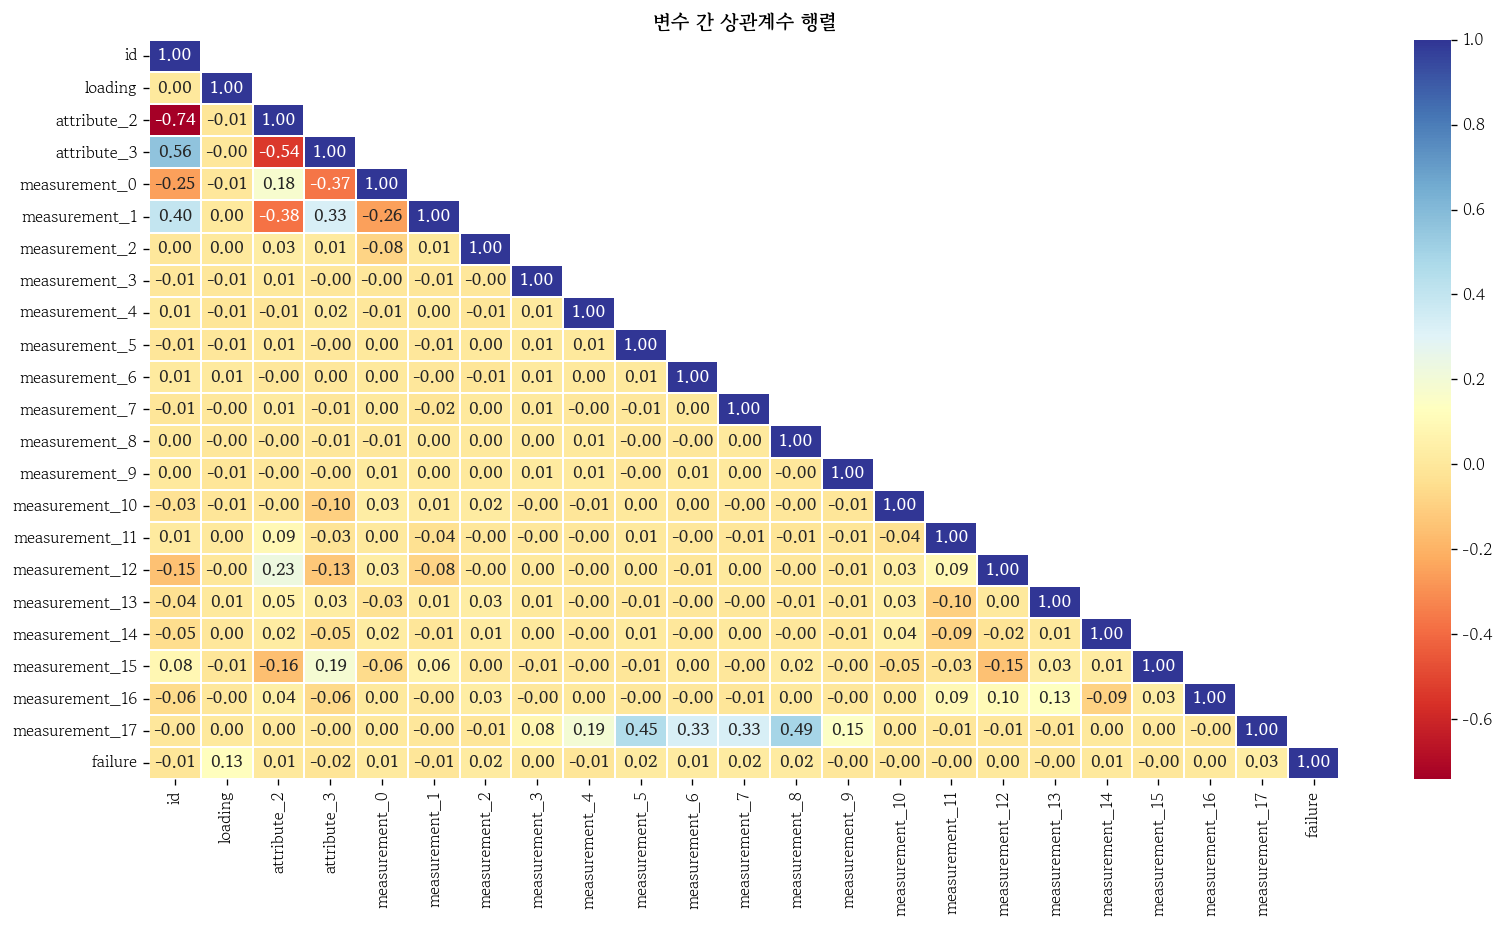

In [10283]:
plt.figure(figsize=(16,8))
hds.plot.corr_heatmap(train, fontsize=10)

In [10284]:
X['log_loading'] = np.log1p(X['loading'])
X_test['log_loading'] = np.log1p(X_test['loading'])

In [10285]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(n_quantiles=500, output_distribution='normal', random_state=0)
X['qt_loading'] = qt.fit_transform(X[['loading']])
X_test['qt_loading'] = qt.transform(X_test[['loading']])

In [10286]:
# X['attribute'] = X['attribute_2'].astype(int) * X['attribute_3'].astype(int)
# X_test['attribute'] = X_test['attribute_2'].astype(int) * X_test['attribute_3'].astype(int)

In [10287]:
X['a2_m1'] = X['attribute_2'].astype(int) * X['measurement_1'].astype(int)
X_test['a2_m1'] = X_test['attribute_2'].astype(int) * X_test['measurement_1'].astype(int)

In [10288]:
# X['a3_m0'] = X['attribute_3'].astype(int) * X['measurement_0'].astype(int)
# X_test['a3_m0'] = X_test['attribute_3'].astype(int) * X_test['measurement_0'].astype(int)

In [10289]:
# X['a3_m1'] = X['attribute_3'].astype(int) * X['measurement_1'].astype(int)
# X_test['a3_m1'] = X_test['attribute_3'].astype(int) * X_test['measurement_1'].astype(int)

In [10290]:
# X['m1_m0_diff'] = X['measurement_1'].astype(int) - X['measurement_0'].astype(int)
# X_test['m1_m0_diff'] = X_test['measurement_1'].astype(int) - X_test['measurement_0'].astype(int)

In [10291]:
# X['m2_m1_diff'] = X['measurement_2'].astype(int) - X['measurement_1'].astype(int)
# X_test['m2_m1_diff'] = X_test['measurement_2'].astype(int) - X_test['measurement_1'].astype(int)

In [10292]:
X['a2_m12'] = X['attribute_2'] * X['measurement_12']
X_test['a2_m12'] = X_test['attribute_2'] * X_test['measurement_12']

In [10293]:
# X['a3_m15'] = X['attribute_3'].astype(int) * X['measurement_15'].astype(int)
# X_test['a3_m15'] = X_test['attribute_3'].astype(int) * X_test['measurement_15'].astype(int)

In [10294]:
X['a3_m17_isna'] = X['attribute_3'] * X['m17_isna']
X_test['a3_m17_isna'] = X_test['attribute_3'] * X_test['m17_isna']

In [10295]:
X['load_m17_isna'] = X['loading'] * X['m17_isna']
X_test['load_m17_isna'] = X_test['loading'] * X_test['m17_isna']

In [10296]:
# X['load_at3'] = X['loading'] * X['attribute_3']
# X_test['load_at3'] = X_test['loading'] * X_test['attribute_3']

In [10297]:
# X['a3_m17'] = X['attribute_3'] * X['measurement_17']
# X_test['a3_m17'] = X_test['attribute_3'] * X_test['measurement_17']

In [10298]:
X['load_bin'], bins = pd.qcut(X['loading'], q=5, retbins=True, labels=False)
X_test['load_bin'] = pd.cut(X_test['loading'], bins=bins, labels=False, include_lowest=True)

In [10299]:
# X['load_bin_m17'] = X['load_bin'] * X['measurement_17']
# X_test['load_bin_m17'] = X_test['load_bin'] * X_test['measurement_17']

In [10300]:
# X['load_bin_a3'] = X['load_bin'] * X['attribute_3']
# X_test['load_bin_a3'] = X_test['load_bin'] * X_test['attribute_3']

In [10301]:
X['m17_resid'] = X['measurement_17'] - (X['loading'] * 0.3)
X_test['m17_resid'] = X_test['measurement_17'] - (X_test['loading'] * 0.3)

In [10302]:
# X['a0_qt_load'] = (X['attribute_0'] == 'material_7').astype(int) * X['qt_loading']
# X_test['a0_qt_load'] = (X_test['attribute_0'] == 'material_7').astype(int) * X_test['qt_loading']

In [10303]:
# X['a0_load_bin'] = (X['attribute_0'] == 'material_7').astype(int) * X['load_bin']
# X_test['a0_load_bin'] = (X_test['attribute_0'] == 'material_7').astype(int) * X_test['load_bin']

In [10304]:
# X['a0_m17_isna'] = (X['attribute_0'] == 'material_7').astype(int) * X['m17_isna']
# X_test['a0_m17_isna'] = (X_test['attribute_0'] == 'material_7').astype(int) * X_test['m17_isna']

In [10305]:
# X['load_stress_ratio'] = X['loading'] / (X['measurement_0'] + X['measurement_1'] + 1)
# X_test['load_stress_ratio'] = X_test['loading'] / (X_test['measurement_0'] + X_test['measurement_1'] + 1)

In [10306]:
# X['stress_threshold'] = (X['load_stress_ratio'] > X['load_stress_ratio'].quantile(0.95)).astype(int)
# X_test['stress_threshold'] = (X_test['load_stress_ratio'] > X_test['load_stress_ratio'].quantile(0.95)).astype(int)

In [10307]:
# X['cluster_load_impact'] = (X['cluster_null'] == '2').astype(int) * X['loading']
# X_test['cluster_load_impact'] = (X_test['cluster_null'] == '2').astype(int) * X_test['loading']

In [10308]:
# 중위수 절대 편차 계산 함수
def get_mad(row):
    median = row.median()
    return (row - median).abs().median()

In [10309]:
target_m = ['qt_loading', 'measurement_17', 'measurement_2', 'measurement_5']

X['mad'] = X[target_m].apply(get_mad, axis=1)
X_test['mad'] = X_test[target_m].apply(get_mad, axis=1)

## 불필요한 컬럼 삭제

In [10310]:
X.columns

Index(['product_code', 'loading', 'attribute_0', 'attribute_1', 'attribute_2',
       'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2',
       'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6',
       'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10',
       'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14',
       'measurement_15', 'measurement_16', 'measurement_17', 'null_count',
       'm17_isna', 'cluster_null', 'log_loading', 'qt_loading', 'a2_m1',
       'a2_m12', 'a3_m17_isna', 'load_m17_isna', 'load_bin', 'm17_resid',
       'mad'],
      dtype='object')

In [10311]:
# 삭제할 컬럼 리스트
cols = ['measurement_0', 'measurement_1', 'measurement_3', 'measurement_4',
    'measurement_6', 'measurement_9', 'measurement_10', 'measurement_11', 
    'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 
    'measurement_16', 'product_code', 'attribute_1', 'attribute_2', 'log_loading']

In [10312]:
X = X.drop(columns=cols)
X_test = X_test.drop(columns=cols)

In [10313]:
numeric_features = X.select_dtypes(include = ['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include = ['object']).columns.tolist()
print(numeric_features)
print()
print(categorical_features)

['loading', 'attribute_3', 'measurement_2', 'measurement_5', 'measurement_7', 'measurement_8', 'measurement_17', 'null_count', 'm17_isna', 'qt_loading', 'a2_m1', 'a2_m12', 'a3_m17_isna', 'load_m17_isna', 'load_bin', 'm17_resid', 'mad']

['attribute_0', 'cluster_null']


In [10314]:
# 최종 사용 컬럼
X.columns

Index(['loading', 'attribute_0', 'attribute_3', 'measurement_2',
       'measurement_5', 'measurement_7', 'measurement_8', 'measurement_17',
       'null_count', 'm17_isna', 'cluster_null', 'qt_loading', 'a2_m1',
       'a2_m12', 'a3_m17_isna', 'load_m17_isna', 'load_bin', 'm17_resid',
       'mad'],
      dtype='object')

In [10315]:
X.describe().round(3)

,loading,attribute_3,measurement_2,measurement_5,measurement_7,measurement_8,measurement_17,null_count,m17_isna,qt_loading,a2_m1,a2_m12,a3_m17_isna,load_m17_isna,load_bin,m17_resid,mad
count,26570.000,26570.000,26570.000,26570.000,26570.000,26570.000,26570.000,26570.000,26570.000,26570.000,26570.000,26570.000,26570.000,26570.000,26570.000,26570.000,26570.000
mean,127.775,7.240,6.257,17.128,11.716,19.025,701.256,0.763,0.086,-0.007,53.267,79.512,0.622,10.899,2.000,662.924,8.576
std,38.850,1.456,3.309,0.984,0.983,0.988,121.292,0.852,0.280,1.010,27.191,21.664,2.074,37.248,1.414,121.858,0.706
min,33.160,5.000,0.000,12.073,7.968,15.217,196.787,0.000,0.000,-5.199,0.000,25.905,0.000,0.000,0.000,163.703,5.845
25%,100.210,6.000,4.000,16.466,11.074,18.376,620.660,0.000,0.000,-0.675,35.000,62.020,0.000,0.000,1.000,582.108,8.104
50%,122.390,8.000,6.000,17.132,11.712,19.021,701.061,1.000,0.000,-0.010,48.000,74.328,0.000,0.000,2.000,662.831,8.575
75%,148.838,8.000,8.000,17.785,12.364,19.676,782.284,1.000,0.000,0.678,70.000,96.232,0.000,0.000,3.000,743.868,9.047
max,385.860,9.000,24.000,21.425,15.419,23.807,1312.794,6.000,1.000,5.199,216.000,156.528,9.000,317.630,4.000,1282.479,12.465


## 파이프라인 정의

- 수치형: 결측을 중앙값으로 채우고 표준화
- 범주형: 결측을 최빈값으로 채우고 원-핫 인코딩

In [10316]:
# 파이프라인
numeric_transformer = Pipeline(
    steps = [
        ('scaler', RobustScaler())
    ]
)

categorical_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy = 'most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    ]
)

preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)

## 훈련셋과 검증셋으로 분할

In [10317]:
# 훈련셋과 검증셋으로 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 0,
    stratify = y
)

In [10318]:
# 훈련셋과 검증셋의 행 개수와 열 개수 확인
print(X_train.shape)
print(X_valid.shape)

(21256, 19)
(5314, 19)


## 모델 생성

In [10319]:
# 로지스틱 회귀 모델 생성
model = LogisticRegression(max_iter = 1000, n_jobs = -1, C=0.046, solver='liblinear')

# 랜던 포레스트 파이프라인 정의
clf = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('model', model),
    ]
)

## 베이스라인 모델 파이프라인 정의

In [10320]:
# 베이스라인 모델 학습
clf.fit(X = X_train, y = y_train)

/opt/anaconda3/envs/sesac_edu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 검증셋 ROC-AUC 확인

In [10321]:
# 베이스라인 모델

# 검증셋 예측확률 생성: 2차원 배열이므로 두 번째 열만 선택
y_valid_prob = clf.predict_proba(X = X_valid)[:, 1]

In [10322]:
# 검증셋 예측확률로 ROC-AUC 점수 확인
y_valid_auc = roc_auc_score(y_true = y_valid, y_score = y_valid_prob)
print(f'{y_valid_auc:.5f}')

0.59968


## K-Fold 일반화 테스트

In [10323]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(clf, X, y, cv=skf, scoring='roc_auc', n_jobs=-1)
print(f"전체 CV AUC 평균: {cv_scores.mean():.5f}")
print(f"Fold별 편차: {cv_scores.std():.5f}")

/opt/anaconda3/envs/sesac_edu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
/opt/anaconda3/envs/sesac_edu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
/opt/anaconda3/envs/sesac_edu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
/opt/anaconda3/envs/sesac_edu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


전체 CV AUC 평균: 0.59075
Fold별 편차: 0.00659


/opt/anaconda3/envs/sesac_edu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


In [10324]:
feature_names = clf['preprocess'].get_feature_names_out()
coef = clf['model'].coef_[0]

pd.Series(coef, index=feature_names).sort_values(key=abs, ascending=False)

cat__cluster_null_0           -0.467774
cat__attribute_0_material_5   -0.355248
cat__attribute_0_material_7   -0.262840
num__qt_loading                0.216648
num__loading                   0.162215
cat__cluster_null_2           -0.108967
num__a3_m17_isna              -0.099400
num__mad                       0.092046
num__load_bin                  0.081631
num__measurement_2             0.055785
num__measurement_7             0.041815
cat__cluster_null_1           -0.041347
num__measurement_8             0.038728
num__measurement_17            0.037769
num__measurement_5            -0.032344
num__a2_m12                    0.028031
num__a2_m1                    -0.022359
num__m17_resid                 0.016470
num__m17_isna                 -0.006444
num__attribute_3               0.004154
num__load_m17_isna             0.002354
num__null_count               -0.001217
dtype: float64

## 전체 훈련셋으로 재학습
- 시험셋 예측값을 생성하기 전, 전체 훈련셋(X, y)로 재학습을 해야 모델의 성능이 향상됨

In [10325]:
# 베이스라인 모델

# 전체 훈련셋으로 재학습
clf.fit(X = X, y = y)

/opt/anaconda3/envs/sesac_edu/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 시험셋 예측값 생성

In [10326]:
# 베이스라인 모델

# 시험셋 예측확률 생성: 2차원 배열이므로 두 번째 열만 선택
y_test_prob = clf.predict_proba(X = X_test)[:, 1]

## 제출 파일 생성
- sample_submission.csv 형식 그대로 사용

In [10327]:
# 제출 파일용 데이터 불러오기
submit = pd.read_csv('sample_submission.csv')

In [10328]:
# submit의 처음 5행 확인
submit.head()

,id,failure
0,26570,0.0
1,26571,0.0
2,26572,0.0
3,26573,0.0
4,26574,0.0


In [10329]:
# test와 submit의 행 개수와 열 개수 확인
print(test.shape)
print(submit.shape)

(20775, 25)
(20775, 2)


In [10330]:
# submit의 failure에 시험셋 에측확률 할당
submit[yvar] = y_test_prob

In [10331]:
# submit의 처음 5행 확인
submit.head()

,id,failure
0,26570,0.189259
1,26571,0.159155
2,26572,0.166317
3,26573,0.170916
4,26574,0.323733


In [10332]:
# 제출 파일 생성
key = 'c_0046'
submit_filename = f'{key}_model.csv'
submit.to_csv(path_or_buf = submit_filename, index = False)

## End of Document